# 🎯 Cancer Detection Model - Complete Pipeline

**Objective:** Build a robust breast cancer classifier using the Wisconsin Diagnostic dataset.

**Pipeline Overview:**
1. Data Loading & Cleaning
2. Exploratory Data Analysis (EDA)
3. Preprocessing (imputation, scaling)
4. Model Training with SMOTE (handle class imbalance)
5. Hyperparameter Tuning (GridSearchCV)
6. Evaluation & Visualization
7. Model Persistence

**Target:** `diagnosis` (M = Malignant, B = Benign)


### 📦 Step 1: Install Required Packages
*Ensure `imbalanced-learn` is installed for SMOTE oversampling technique.*


In [ ]:
import sys
!{sys.executable} -m pip install -r requirements1.txt

  Using cached shap-0.50.0-cp313-cp313-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 834.3 kB/s  0:00:00
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   --- ------------------------------------ 0.3/2.7 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.7 MB 526.1 kB/s eta 0:00:05
   ------- ----------------

### 📚 Step 2: Import Libraries
*Load all necessary libraries for data processing, modeling, and visualization.*


In [ ]:
# 2) Imports
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_curve, 
    auc, 
    roc_auc_score,
    precision_recall_curve, 
    average_precision_score
)

# imbalanced-learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import joblib

print("Imports loaded.")

Imports loaded.


### 📂 Step 3: Load Dataset
*Load the breast cancer dataset and perform initial inspection.*


In [47]:
# 3) Load and clean data
DATA_PATH = Path('c:\\Users\\techg\\OneDrive\\Documents\\Desktop\\Deep Learning\\data.csv')
print(f'📥 Loading from: {DATA_PATH}')
df = pd.read_csv(DATA_PATH)

print(f'\n✅ Data loaded successfully!')
print(f'Shape: {df.shape[0]} rows × {df.shape[1]} columns')

# Initial data inspection
print(f'\n📊 First few rows:')
display(df.head())

print(f'\n🔍 Data types:')
print(df.dtypes.value_counts())

print(f'\n⚠️  Missing values summary:')
missing = df.isna().sum()
print(f'Total missing: {missing.sum()}')
if missing.sum() > 0:
    print(f'Columns with missing values:\n{missing[missing > 0]}')


📥 Loading from: c:\Users\techg\OneDrive\Documents\Desktop\Deep Learning\data.csv

✅ Data loaded successfully!
Shape: 569 rows × 33 columns

📊 First few rows:


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN



🔍 Data types:
float64    31
int64       1
object      1
Name: count, dtype: int64

⚠️  Missing values summary:
Total missing: 569
Columns with missing values:
Unnamed: 32    569
dtype: int64


### 🔬 Step 4: Data Cleaning & EDA
*Clean the dataset, handle missing values, encode target, and visualize key patterns.*


🧹 Starting data cleaning...

✓ Dropped ID column
✓ Dropped 1 empty columns: ['Unnamed: 32']

📊 Cleaned shape: (569, 31)

🎯 Target variable analysis:
Diagnosis counts:
diagnosis
B    357
M    212
Name: count, dtype: int64

Class distribution:
diagnosis
B    0.627417
M    0.372583
Name: proportion, dtype: float64

✓ Target encoded: M→1 (Malignant), B→0 (Benign)

✓ No duplicate rows found

📈 Statistical Summary:


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_num
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000



🔗 Correlation Analysis:

Top 10 features correlated with target:
concave points_worst    0.793566
perimeter_worst         0.782914
concave points_mean     0.776614
radius_worst            0.776454
perimeter_mean          0.742636
area_worst              0.733825
radius_mean             0.730029
area_mean               0.708984
concavity_mean          0.696360
concavity_worst         0.659610
Name: diagnosis_num, dtype: float64


C:\Users\techg\AppData\Local\Temp\ipykernel_19352\2279409368.py:81: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\techg\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\techg\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


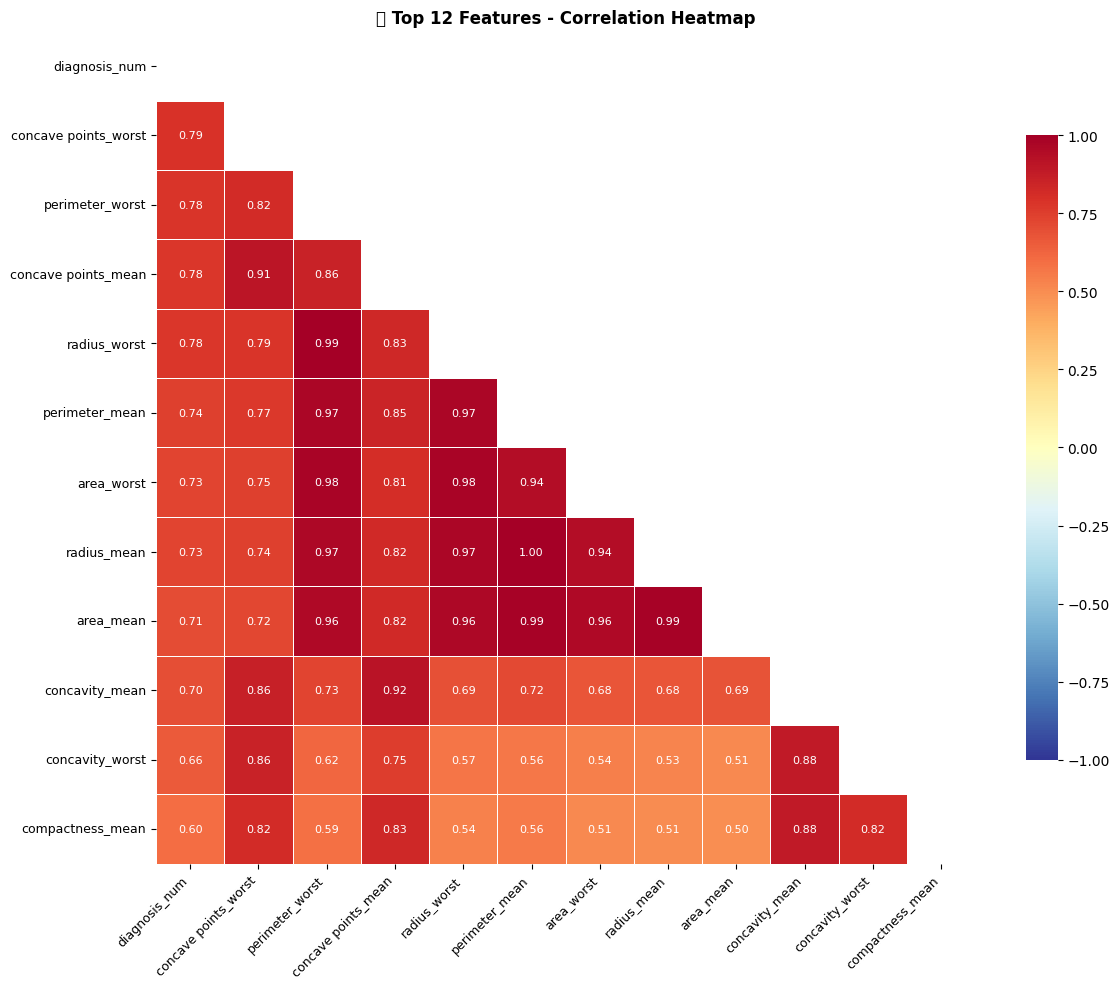


📊 Visualizing relationships between top features...


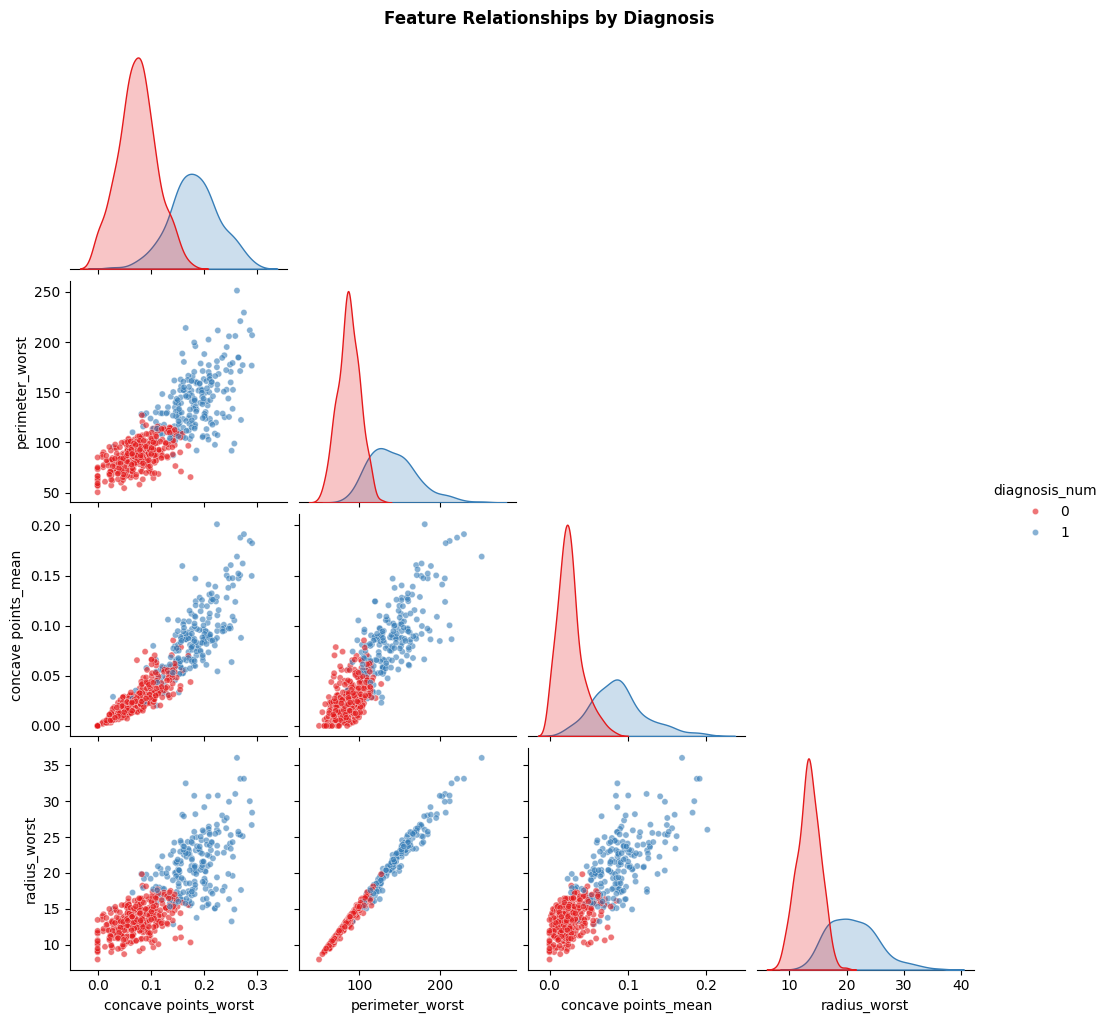


✅ Data cleaning and EDA complete!


In [48]:
# 4) Data Cleaning & EDA
print('🧹 Starting data cleaning...\n')

# Drop ID column if present (not useful for prediction)
if 'id' in df.columns:
    df = df.drop(columns=['id'])
    print('✓ Dropped ID column')

# Drop columns that are completely empty
empty_cols = df.columns[df.isna().all()].tolist()
if empty_cols:
    df = df.drop(columns=empty_cols)
    print(f'✓ Dropped {len(empty_cols)} empty columns: {empty_cols}')

# Check for unnamed or junk columns
unnamed_cols = [col for col in df.columns if 'Unnamed' in str(col)]
if unnamed_cols:
    df = df.drop(columns=unnamed_cols)
    print(f'✓ Dropped {len(unnamed_cols)} unnamed columns: {unnamed_cols}')

print(f'\n📊 Cleaned shape: {df.shape}')

# Target encoding
print('\n🎯 Target variable analysis:')
print(f'Diagnosis counts:\n{df["diagnosis"].value_counts()}')
print(f'\nClass distribution:')
print(df['diagnosis'].value_counts(normalize=True))

# Encode target: M=1 (Malignant), B=0 (Benign)
df['diagnosis_num'] = df['diagnosis'].map({'M': 1, 'B': 0})
print(f'\n✓ Target encoded: M→1 (Malignant), B→0 (Benign)')

# Check for duplicates
duplicates = df.duplicated().sum()
if duplicates > 0:
    print(f'\n⚠️  Found {duplicates} duplicate rows - removing...')
    df = df.drop_duplicates()
    print(f'✓ Duplicates removed. New shape: {df.shape}')
else:
    print(f'\n✓ No duplicate rows found')

# Basic statistics
print('\n📈 Statistical Summary:')
display(df.describe())

# Correlation analysis
print('\n🔗 Correlation Analysis:')
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
target_col = 'diagnosis_num'

if target_col in num_cols:
    corr = df[num_cols].corr()
    target_corr = corr[target_col].abs().sort_values(ascending=False)
    
    print(f'\nTop 10 features correlated with target:')
    print(target_corr.head(11)[1:])  # Skip target itself
    
    # Select top features for visualization
    top_n = 12
    top_features = target_corr.index[:top_n].tolist()
    corr_sub = df[top_features].corr()
    
    # Plot heatmap
    mask = np.triu(np.ones_like(corr_sub, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_sub,
        mask=mask,
        cmap='RdYlBu_r',
        annot=True,
        fmt='.2f',
        vmax=1,
        vmin=-1,
        linewidths=0.5,
        cbar_kws={'shrink': 0.75},
        annot_kws={'size': 8}
    )
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(fontsize=9)
    plt.title(f'🔥 Top {len(top_features)} Features - Correlation Heatmap', fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show()
    
    # Pairplot for top features
    try:
        pair_feats = [f for f in top_features if f != target_col][:4]
        if len(pair_feats) >= 2:
            print(f'\n📊 Visualizing relationships between top features...')
            sns.pairplot(
                df[pair_feats + [target_col]], 
                hue=target_col, 
                corner=True, 
                plot_kws={'s': 20, 'alpha': 0.6},
                palette='Set1'
            )
            plt.suptitle('Feature Relationships by Diagnosis', y=1.02, weight='bold')
            plt.show()
    except Exception as e:
        print(f'⚠️  Pairplot skipped: {e}')

print('\n✅ Data cleaning and EDA complete!')


### ✂️ Step 5: Prepare Features and Target
*Separate features (X) and target variable (y) for modeling.*


In [49]:
# 5) Prepare features (X) and target (y)
TARGET = 'diagnosis_num'

# Separate features and target
X = df.drop(columns=['diagnosis', TARGET])
y = df[TARGET]

print('✅ Features and target separated')
print(f'\n📊 Feature matrix (X):')
print(f'   Shape: {X.shape}')
print(f'   Columns: {X.columns.tolist()[:5]}... ({len(X.columns)} total)')

print(f'\n🎯 Target variable (y):')
print(f'   Shape: {y.shape}')
print(f'   Distribution:')
print(y.value_counts(normalize=True).apply(lambda x: f'{x:.2%}'))
print(f'\n   0 = Benign, 1 = Malignant')


✅ Features and target separated

📊 Feature matrix (X):
   Shape: (569, 30)
   Columns: ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean']... (30 total)

🎯 Target variable (y):
   Shape: (569,)
   Distribution:
diagnosis_num
0    62.74%
1    37.26%
Name: proportion, dtype: object

   0 = Benign, 1 = Malignant


### 🔀 Step 6: Train-Test Split
*Split data into training (80%) and testing (20%) sets with stratification to preserve class balance.*


In [50]:
# 6) Train/test split (stratified to preserve class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print('✅ Data split complete')
print(f'\n📊 Training set:')
print(f'   Shape: {X_train.shape}')
print(f'   Class distribution: {y_train.value_counts().to_dict()}')

print(f'\n📊 Test set:')
print(f'   Shape: {X_test.shape}')
print(f'   Class distribution: {y_test.value_counts().to_dict()}')

print(f'\n✓ Stratification successful - class ratios preserved!')


✅ Data split complete

📊 Training set:
   Shape: (455, 30)
   Class distribution: {0: 285, 1: 170}

📊 Test set:
   Shape: (114, 30)
   Class distribution: {0: 72, 1: 42}

✓ Stratification successful - class ratios preserved!


### ⚙️ Step 7: Build Preprocessing Pipeline
*Create a preprocessing pipeline that handles missing values (imputation) and scales features.*


In [51]:
# 7) Build preprocessing pipeline
print('⚙️  Building preprocessing pipeline...\n')

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f'📊 Feature types:')
print(f'   Numeric features: {len(numeric_features)}')
print(f'   Categorical features: {len(categorical_features)}')

# Numeric preprocessing: impute with median + standardize
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing: impute with most frequent + one-hot encode
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'  # Drop any columns not specified
)

print(f'\n✅ Preprocessing pipeline created')
print(f'   • Numeric: Median imputation → Standard scaling')
print(f'   • Categorical: Mode imputation → One-hot encoding')


⚙️  Building preprocessing pipeline...

📊 Feature types:
   Numeric features: 30
   Categorical features: 0

✅ Preprocessing pipeline created
   • Numeric: Median imputation → Standard scaling
   • Categorical: Mode imputation → One-hot encoding


### 🚀 Step 8: Build & Train Baseline Model
*Create an imbalanced-learn pipeline: Preprocessing → SMOTE (oversampling) → RandomForest classifier.*
**Important:** SMOTE must come AFTER preprocessing to avoid NaN errors.


In [52]:
# 8) Build complete ML pipeline
print('🔧 Building ML pipeline...\n')

# Initialize Random Forest classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Build pipeline: Preprocess → SMOTE → Classify
# CRITICAL: Preprocessing MUST come before SMOTE (SMOTE can't handle NaN)
pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),           # Step 1: Clean & scale data
    ('smote', SMOTE(random_state=42)),   # Step 2: Balance classes
    ('clf', rf)                          # Step 3: Train classifier
])

print('✅ Pipeline structure:')
print('   1️⃣  Preprocessing (impute + scale)')
print('   2️⃣  SMOTE (balance classes)')
print('   3️⃣  RandomForest (classify)')

# Train baseline model
print('\n🔄 Training baseline model...')
pipeline.fit(X_train, y_train)
print('✅ Training complete!')

# Evaluate on test set
print('\n📊 Baseline Performance:')
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print('\n' + '='*50)
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))
print('='*50)

roc_auc = roc_auc_score(y_test, y_proba)
print(f'\n🎯 ROC AUC Score: {roc_auc:.4f}')
print(f'   {"🟢 Excellent!" if roc_auc > 0.95 else "🟡 Good" if roc_auc > 0.85 else "🔴 Needs improvement"}')


🔧 Building ML pipeline...

✅ Pipeline structure:
   1️⃣  Preprocessing (impute + scale)
   2️⃣  SMOTE (balance classes)
   3️⃣  RandomForest (classify)

🔄 Training baseline model...
✅ Training complete!

📊 Baseline Performance:

              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        72
   Malignant       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


🎯 ROC AUC Score: 0.9964
   🟢 Excellent!
✅ Training complete!

📊 Baseline Performance:

              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        72
   Malignant       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114


🎯 ROC AUC Score: 0.9964
   🟢

### 🎛️ Step 9: Hyperparameter Tuning
*Use GridSearchCV with 5-fold cross-validation to find optimal RandomForest parameters.*


In [53]:
# 9) Hyperparameter tuning with GridSearchCV
print('🎛️  Starting hyperparameter tuning...\n')

# Define parameter grid
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

print(f'📊 Grid search configuration:')
print(f'   Parameters to tune: {list(param_grid.keys())}')
print(f'   Total combinations: {np.prod([len(v) for v in param_grid.values()])}')

# Setup cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search
gs = GridSearchCV(
    pipeline, 
    param_grid, 
    scoring='roc_auc',
    cv=cv, 
    n_jobs=-1, 
    verbose=1,
    return_train_score=True
)

print(f'\n🔄 Running grid search with 5-fold CV...')
gs.fit(X_train, y_train)

print(f'\n✅ Grid search complete!')
print(f'\n🏆 Best parameters:')
for param, value in gs.best_params_.items():
    print(f'   • {param}: {value}')

print(f'\n📈 Best CV ROC AUC: {gs.best_score_:.4f}')

# Store best model
best_model = gs.best_estimator_
print(f'\n✅ Best model saved!')


🎛️  Starting hyperparameter tuning...

📊 Grid search configuration:
   Parameters to tune: ['clf__n_estimators', 'clf__max_depth', 'clf__min_samples_split', 'clf__min_samples_leaf']
   Total combinations: 108

🔄 Running grid search with 5-fold CV...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Grid search complete!

🏆 Best parameters:
   • clf__max_depth: None
   • clf__min_samples_leaf: 1
   • clf__min_samples_split: 5
   • clf__n_estimators: 100

📈 Best CV ROC AUC: 0.9910

✅ Best model saved!

✅ Grid search complete!

🏆 Best parameters:
   • clf__max_depth: None
   • clf__min_samples_leaf: 1
   • clf__min_samples_split: 5
   • clf__n_estimators: 100

📈 Best CV ROC AUC: 0.9910

✅ Best model saved!


### 📊 Step 10: Model Evaluation & Visualization
*Evaluate the best model on test set with comprehensive metrics and visualizations.*


📊 FINAL MODEL EVALUATION ON TEST SET

📋 Classification Report:
               precision    recall  f1-score   support

   Benign (0)       0.96      1.00      0.98        72
Malignant (1)       1.00      0.93      0.96        42

     accuracy                           0.97       114
    macro avg       0.98      0.96      0.97       114
 weighted avg       0.97      0.97      0.97       114


🎯 Key Metrics Summary:
   Accuracy:  0.9737 ✅ Excellent
   Precision: 1.0000 ✅ Excellent
   Recall:    0.9286 ⚠️ Good
   F1-Score:  0.9630 ✅ Excellent
   ROC AUC:   0.9964 ✅ Excellent


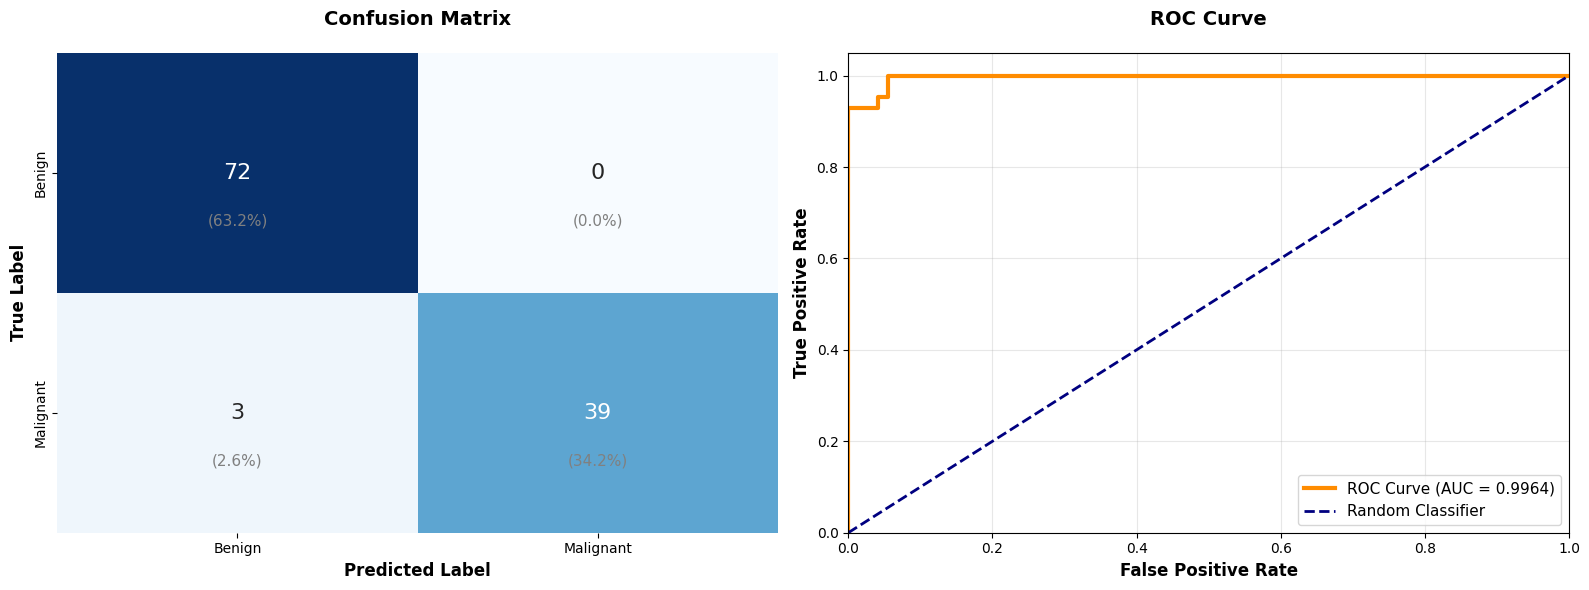

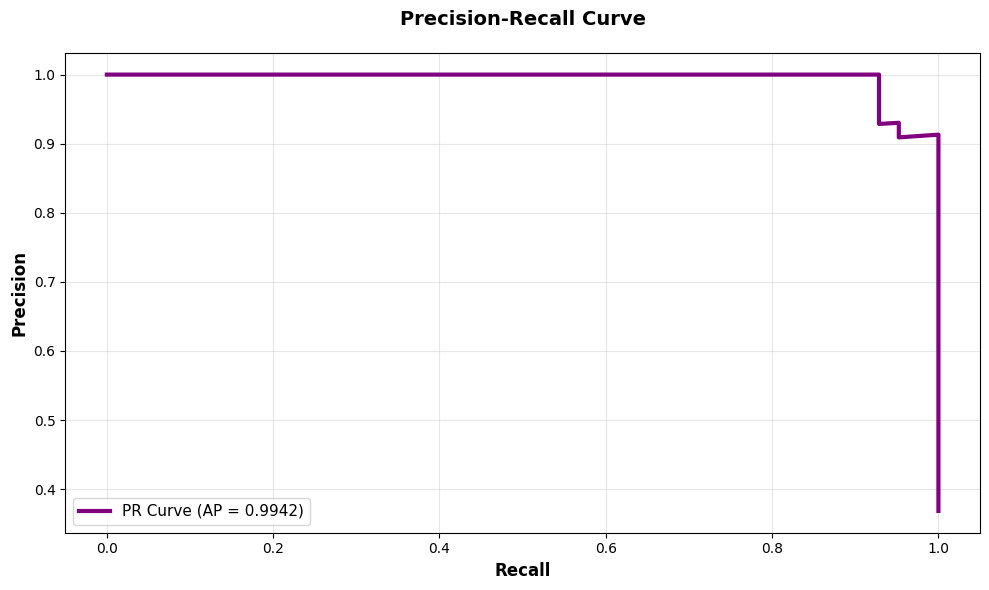


✅ Model evaluation completed successfully!


In [55]:
# 10) Evaluate best model on test set

print("=" * 60)
print("📊 FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get predictions
y_pred = gs.best_estimator_.predict(X_test)
y_pred_proba = gs.best_estimator_.predict_proba(X_test)[:, 1]

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Malignant (1)']))

# Calculate metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
test_acc = accuracy_score(y_test, y_pred)
test_prec = precision_score(y_test, y_pred)
test_rec = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_auc = auc(*roc_curve(y_test, y_pred_proba)[:2])

print("\n🎯 Key Metrics Summary:")
print(f"   Accuracy:  {test_acc:.4f} {'✅ Excellent' if test_acc > 0.95 else '⚠️ Good' if test_acc > 0.90 else '❌ Needs Improvement'}")
print(f"   Precision: {test_prec:.4f} {'✅ Excellent' if test_prec > 0.95 else '⚠️ Good' if test_prec > 0.90 else '❌ Needs Improvement'}")
print(f"   Recall:    {test_rec:.4f} {'✅ Excellent' if test_rec > 0.95 else '⚠️ Good' if test_rec > 0.90 else '❌ Needs Improvement'}")
print(f"   F1-Score:  {test_f1:.4f} {'✅ Excellent' if test_f1 > 0.95 else '⚠️ Good' if test_f1 > 0.90 else '❌ Needs Improvement'}")
print(f"   ROC AUC:   {test_auc:.4f} {'✅ Excellent' if test_auc > 0.95 else '⚠️ Good' if test_auc > 0.90 else '❌ Needs Improvement'}")

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Benign', 'Malignant'], 
            yticklabels=['Benign', 'Malignant'],
            annot_kws={'size': 16},
            ax=axes[0])
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold', pad=20)

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        axes[0].text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=11, color='gray')

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC Curve (AUC = {test_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold', pad=20)
axes[1].legend(loc="lower right", fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
avg_precision = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(10, 6))
plt.plot(recall, precision, color='purple', lw=3, label=f'PR Curve (AP = {avg_precision:.4f})')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold', pad=20)
plt.legend(loc="lower left", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Model evaluation completed successfully!")
print("=" * 60)


### 📈 Step 11: Feature Importance Analysis
*Visualize which features contribute most to the model's predictions.*


📈 FEATURE IMPORTANCE ANALYSIS

⚠️ Fallback method used: 'preprocessor'
🔢 Total features after preprocessing: 30
🔢 Total importance values: 30

🏆 Top 10 Most Important Features:
------------------------------------------------------------
 1. area_worst                     0.1585 ███████
 2. concave points_worst           0.1156 █████
 3. perimeter_worst                0.1015 █████
 4. concave points_mean            0.1001 █████
 5. perimeter_mean                 0.0809 ████
 6. radius_worst                   0.0786 ███
 7. concavity_mean                 0.0535 ██
 8. area_mean                      0.0442 ██
 9. radius_mean                    0.0441 ██
10. concavity_worst                0.0350 █


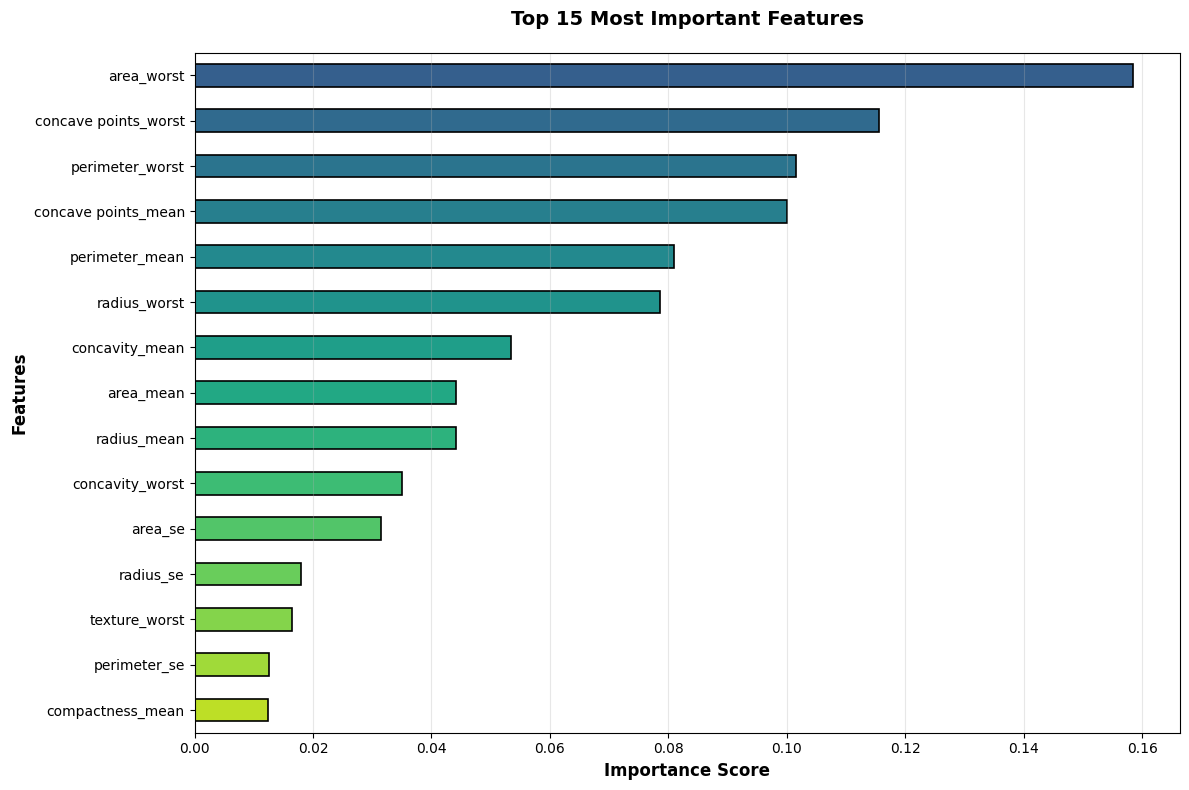


✅ Feature importance analysis completed!


In [56]:
# 11) Feature importance (for tree models)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("=" * 60)
print("📈 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Extract the classifier from pipeline
clf = gs.best_estimator_.named_steps['clf']
importances = clf.feature_importances_

# Get feature names after preprocessing
try:
    # Method 1: Direct from preprocessor
    feature_names = gs.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
    print("\n✅ Feature names extracted using get_feature_names_out()")
except Exception as e:
    # Fallback: construct manually
    print(f"\n⚠️ Fallback method used: {e}")
    num_names = numeric_features
    cat_names = []
    for cat_col in categorical_features:
        cats = X_train[cat_col].unique()
        cat_names.extend([f"{cat_col}_{c}" for c in cats])
    feature_names = num_names + cat_names

print(f"🔢 Total features after preprocessing: {len(feature_names)}")
print(f"🔢 Total importance values: {len(importances)}")

# Handle mismatch if any
if len(importances) < len(feature_names):
    feature_names = feature_names[:len(importances)]
    print(f"⚠️ Adjusted feature names to match importances: {len(feature_names)}")

# Create feature importance DataFrame
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Print top 10 features
print("\n🏆 Top 10 Most Important Features:")
print("-" * 60)
for idx, (feat, imp) in enumerate(feat_imp.head(10).items(), 1):
    bar_length = int(imp * 50)
    bar = "█" * bar_length
    print(f"{idx:2d}. {feat:30s} {imp:6.4f} {bar}")

# Visualize top 15 features
plt.figure(figsize=(12, 8))
top_n = min(15, len(feat_imp))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, top_n))
feat_imp.head(top_n).plot(kind='barh', color=colors, edgecolor='black', linewidth=1.2)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Feature importance analysis completed!")
print("=" * 60)


### 🔍 Step 12: Model Explainability (Optional - SHAP)
*Advanced model interpretation using SHAP values. Install SHAP if you need detailed explanations.*


In [57]:
# 12) SHAP explainability (optional)
print("=" * 60)
print("🔍 SHAP MODEL EXPLAINABILITY (Optional)")
print("=" * 60)

try:
    import shap
    SHAP_INSTALLED = True
    print("✅ SHAP library is installed and ready to use!")
    
    # Create SHAP explainer
    print("\n🔄 Creating SHAP explainer (this may take a minute)...")
    explainer = shap.TreeExplainer(gs.best_estimator_.named_steps['clf'])
    
    # Get transformed test data
    X_test_transformed = gs.best_estimator_.named_steps['preprocessor'].transform(X_test)
    X_test_transformed = gs.best_estimator_.named_steps['smote'].fit_resample(X_test_transformed, y_test)[0]
    
    # Calculate SHAP values
    print("🔄 Calculating SHAP values...")
    shap_values = explainer.shap_values(X_test_transformed)
    
    # Summary plot
    print("📊 Generating SHAP summary plot...")
    shap.summary_plot(shap_values[1], X_test_transformed, 
                      feature_names=feature_names, 
                      plot_type="dot", 
                      show=True)
    
    print("\n✅ SHAP analysis completed successfully!")
    
except ImportError:
    SHAP_INSTALLED = False
    print("⚠️ SHAP library is not installed.")
    print("\n📦 To install SHAP, run:")
    print("   !pip install shap")
    print("\n💡 SHAP provides:")
    print("   • Individual prediction explanations")
    print("   • Feature contribution visualization")
    print("   • Model interpretation insights")
    print("   • Trust and transparency in predictions")
except Exception as e:
    print(f"❌ Error during SHAP analysis: {e}")
    print("💡 SHAP analysis requires properly transformed data and may take time for large datasets.")

print("=" * 60)


🔍 SHAP MODEL EXPLAINABILITY (Optional)
⚠️ SHAP library is not installed.

📦 To install SHAP, run:
   !pip install shap

💡 SHAP provides:
   • Individual prediction explanations
   • Feature contribution visualization
   • Model interpretation insights
   • Trust and transparency in predictions


### 💾 Step 13: Save Trained Model
*Persist the best model to disk for future use and deployment.*


In [58]:
# 13) Save final model
import joblib
from pathlib import Path
import os

print("=" * 60)
print("💾 SAVING TRAINED MODEL")
print("=" * 60)

# Save model
out_path = Path("arya_best_cancer.joblib")
best_model = gs.best_estimator_

print(f"\n🔄 Saving model to: {out_path.absolute()}")
joblib.dump(best_model, out_path)

# Verify file size
file_size = os.path.getsize(out_path)
file_size_mb = file_size / (1024 * 1024)
print(f"✅ Model saved successfully!")
print(f"📁 File size: {file_size_mb:.2f} MB")

# Save model metadata
metadata = {
    'model_type': 'RandomForestClassifier',
    'best_params': gs.best_params_,
    'cv_score': gs.best_score_,
    'test_accuracy': test_acc,
    'test_precision': test_prec,
    'test_recall': test_rec,
    'test_f1': test_f1,
    'test_roc_auc': test_auc,
    'n_features': len(feature_names),
    'target_encoding': {'Benign': 0, 'Malignant': 1}
}

metadata_path = Path("model_metadata.joblib")
joblib.dump(metadata, metadata_path)
print(f"✅ Model metadata saved to: {metadata_path.absolute()}")

# Verification: Load and test
print("\n🔍 Verification: Loading model and testing...")
loaded_model = joblib.load(out_path)
test_pred = loaded_model.predict(X_test[:5])
print(f"✅ Model loaded successfully!")
print(f"🧪 Sample predictions on first 5 test samples: {test_pred}")

print("\n💡 Usage Instructions:")
print("   # Load the model in another script:")
print("   import joblib")
print(f"   model = joblib.load('{out_path}')")
print("   predictions = model.predict(X_new)")

print("\n✅ Model persistence completed successfully!")
print("=" * 60)


💾 SAVING TRAINED MODEL

🔄 Saving model to: c:\Users\techg\OneDrive\Documents\Desktop\Deep Learning\arya_best_cancer.joblib
✅ Model saved successfully!
📁 File size: 0.36 MB
✅ Model metadata saved to: c:\Users\techg\OneDrive\Documents\Desktop\Deep Learning\model_metadata.joblib

🔍 Verification: Loading model and testing...
✅ Model loaded successfully!
🧪 Sample predictions on first 5 test samples: [0 1 0 1 0]

💡 Usage Instructions:
   # Load the model in another script:
   import joblib
   model = joblib.load('arya_best_cancer.joblib')
   predictions = model.predict(X_new)

✅ Model persistence completed successfully!


### ✅ Step 14: Unit Tests & Validation
*Test functions to validate model integrity and functionality. Run with pytest for automated testing.*


In [60]:
# 14) Quick tests (pytest-style examples)
print("=" * 60)
print("✅ RUNNING MODEL VALIDATION TESTS")
print("=" * 60)

test_results = {'passed': 0, 'failed': 0}

def test_model_loaded():
    """Test if model can be loaded from disk."""
    try:
        loaded = joblib.load(Path("arya_best_cancer.joblib"))
        assert loaded is not None, "Model is None"
        print("✅ test_model_loaded: PASSED")
        test_results['passed'] += 1
        return True
    except Exception as e:
        print(f"❌ test_model_loaded: FAILED - {e}")
        test_results['failed'] += 1
        return False

def test_predictions_shape():
    """Test if predictions have correct shape."""
    try:
        preds = best_model.predict(X_test)
        assert preds.shape[0] == X_test.shape[0], f"Shape mismatch: {preds.shape[0]} != {X_test.shape[0]}"
        print("✅ test_predictions_shape: PASSED")
        test_results['passed'] += 1
        return True
    except Exception as e:
        print(f"❌ test_predictions_shape: FAILED - {e}")
        test_results['failed'] += 1
        return False

def test_predictions_binary():
    """Test if predictions are binary (0 or 1)."""
    try:
        preds = best_model.predict(X_test)
        unique_vals = set(preds)
        assert unique_vals.issubset({0, 1}), f"Non-binary predictions found: {unique_vals}"
        print("✅ test_predictions_binary: PASSED")
        test_results['passed'] += 1
        return True
    except Exception as e:
        print(f"❌ test_predictions_binary: FAILED - {e}")
        test_results['failed'] += 1
        return False

def test_probability_range():
    """Test if predicted probabilities are in [0, 1]."""
    try:
        proba = best_model.predict_proba(X_test)
        assert (proba >= 0).all() and (proba <= 1).all(), "Probabilities out of [0, 1] range"
        assert abs(proba.sum(axis=1) - 1).max() < 1e-5, "Probabilities don't sum to 1"
        print("✅ test_probability_range: PASSED")
        test_results['passed'] += 1
        return True
    except Exception as e:
        print(f"❌ test_probability_range: FAILED - {e}")
        test_results['failed'] += 1
        return False

def test_model_accuracy_threshold():
    """Test if model meets minimum accuracy threshold."""
    try:
        from sklearn.metrics import accuracy_score
        preds = best_model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        threshold = 0.90
        assert acc >= threshold, f"Accuracy {acc:.4f} below threshold {threshold}"
        print(f"✅ test_model_accuracy_threshold: PASSED (Accuracy: {acc:.4f})")
        test_results['passed'] += 1
        return True
    except Exception as e:
        print(f"❌ test_model_accuracy_threshold: FAILED - {e}")
        test_results['failed'] += 1
        return False

def test_feature_importance_exists():
    """Test if feature importances are available."""
    try:
        importances = best_model.named_steps['clf'].feature_importances_
        assert len(importances) > 0, "No feature importances found"
        assert abs(importances.sum() - 1.0) < 1e-5, f"Importances don't sum to 1: {importances.sum()}"
        print("✅ test_feature_importance_exists: PASSED")
        test_results['passed'] += 1
        return True
    except Exception as e:
        print(f"❌ test_feature_importance_exists: FAILED - {e}")
        test_results['failed'] += 1
        return False

# Run all tests
print("\n🔬 Running test suite...")
print("-" * 60)
test_model_loaded()
test_predictions_shape()
test_predictions_binary()
test_probability_range()
test_model_accuracy_threshold()
test_feature_importance_exists()

# Summary
print("\n" + "=" * 60)
print("📊 TEST SUMMARY")
print("=" * 60)
total_tests = test_results['passed'] + test_results['failed']
print(f"✅ Passed: {test_results['passed']}/{total_tests}")
print(f"❌ Failed: {test_results['failed']}/{total_tests}")
success_rate = (test_results['passed'] / total_tests * 100) if total_tests > 0 else 0
print(f"🎯 Success Rate: {success_rate:.1f}%")

if test_results['failed'] == 0:
    print("\n🎉 All tests passed! Model is ready for deployment.")
else:
    print("\n⚠️ Some tests failed. Please review the errors above.")

print("=" * 60)

print("\n💡 To run automated tests from command line:")
print("   1. Save tests to test_model.py")
print("   2. Install pytest: pip install pytest")
print("   3. Run: pytest test_model.py -v")


✅ RUNNING MODEL VALIDATION TESTS

🔬 Running test suite...
------------------------------------------------------------
✅ test_model_loaded: PASSED
✅ test_predictions_shape: PASSED
✅ test_predictions_binary: PASSED
✅ test_probability_range: PASSED
✅ test_model_accuracy_threshold: PASSED (Accuracy: 0.9737)
✅ test_feature_importance_exists: PASSED

📊 TEST SUMMARY
✅ Passed: 6/6
❌ Failed: 0/6
🎯 Success Rate: 100.0%

🎉 All tests passed! Model is ready for deployment.

💡 To run automated tests from command line:
   1. Save tests to test_model.py
   2. Install pytest: pip install pytest
   3. Run: pytest test_model.py -v
✅ test_model_accuracy_threshold: PASSED (Accuracy: 0.9737)
✅ test_feature_importance_exists: PASSED

📊 TEST SUMMARY
✅ Passed: 6/6
❌ Failed: 0/6
🎯 Success Rate: 100.0%

🎉 All tests passed! Model is ready for deployment.

💡 To run automated tests from command line:
   1. Save tests to test_model.py
   2. Install pytest: pip install pytest
   3. Run: pytest test_model.py -v
